In [1]:
import re
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import chain
from collections import Counter

from tqdm import tqdm
tqdm.pandas()

from sklearn.preprocessing import LabelEncoder

sys.path.append('../src')
from encode import *
from label_candidates_extract import LabelCandidatesExtracter

### Обучающая выборка

Для "обучения" алгоритма TopMine, т.е. для подсчёта частотности чанков на шаге Frequent Phrase Mining, формируем список предложений извлечённых из заголовков и текстов.

In [ ]:
articles = pd.read_csv('../data/interim/articles_preproc.csv')

articles.title_preproc = articles.title_preproc.apply(conllu_encoder)
articles.text_preproc = articles.text_preproc.apply(conllu_encoder)

sentences = list(chain(*articles.title_preproc))+list(chain(*articles.text_preproc))

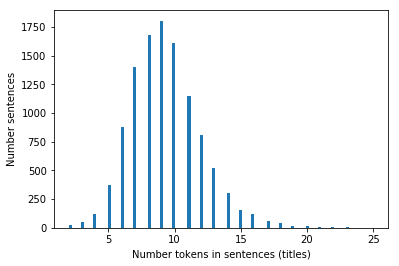

In [8]:
len_titles = articles.title_preproc.apply(lambda x: len(list(chain(*[sent.tokens for sent in x]))))

plt.figure()
plt.hist(len_titles, bins=100)
plt.xlabel('Number tokens in sentences (titles)')
plt.ylabel('Number sentences')
plt.show()

Видим, что заголовки не содердат более 25 слов. Поэтому ограничем длину кандидата в заголовок 50 словами.

In [13]:
lce = LabelCandidatesExtracter(min_count=3, max_len=25).fit(sentences)
lce.dump('../models/label_candidates_extracter')

100%|██████████| 25/25 [00:18<00:00,  7.65it/s]


### Выделение кандидатов в заголовках и текстах статей

Сформируем таблицу candidates.csv кандидатов в заголовки:

* **article_id** - идентификатор новостной статьи
* **part** - часть статьи ('title', 'text')
* **sent_id** - идентификатор предложения
* **sent_n** - количество предложений в тексте
* **sent_len** - количество слов в предложении
* **begin_index** - индекс, с которого начинается фраза в предложении 
* **end_index** - индекс, которым заканчивается фраза в предложении
* **form_id** - идентификатор кандидата (слова в изначальной грамматической форме)
* **lemma_id** - идентификатор кандидата (слова в нормальной грамматической форме)
* **main_pos** - значение pos для главного слова в предложении
* **main_tag** - значение tag для главного слова в предложении
* **sig** - sig из TopMine

Также будут таблицы candidate_forms.csv и candidate_lemmas.csv, в которых храняться соответсвующие фразы и их идентификаторы.

In [14]:
candidates = []
lce = LabelCandidatesExtracter().load('../models/label_candidates_extracter')

for _, article in tqdm(articles.iterrows()):
    
    for part in ['title', 'text']:
        
        sentences =  article[part+'_preproc']
        sent_n = len(sentences)
        
        for sentence in sentences:
            
            tokens = sentence.tokens
            sent_len = len(tokens)
            
            for begin, end, sig in lce.transform(sentence):
            
                candidate = tokens[begin:end]
                
                #не рассматриваем словосочетания начинающиеся и заканчивающиеся пунктуацией
                if candidate[0].pos == 'PUNCT' or candidate[-1].pos == 'PUNCT':
                    continue
                    
                lemma = ''.join([token.lemma+' '*token.space for token in candidate]).strip()
                
                form = ''.join([token.token+' '*token.space for token in candidate]).strip()
                form = form[0].upper()+form[1:]
                
                for token in candidate:
                    if (token.head < begin) or (token.head >= end):
                        main_pos = token.pos
                        break
                
                candidates.append((article.id, part, sentence.id, sent_n, sent_len, 
                                   begin, end, form, lemma, main_pos, sig))
                
columns = ['article_id', 'part', 'sent_id', 'sent_n', 'sent_len', 
           'begin_index', 'end_index', 'form_id', 'lemma_id', 'main_pos', 'sig']

candidates = pd.DataFrame(candidates, columns=columns)

#формируем список кандидатов
label_encoder = LabelEncoder().fit(candidates.form_id)
candidates.form_id = label_encoder.transform(candidates.form_id)

candidate_forms = label_encoder.classes_
candidate_forms = pd.DataFrame({'id':range(len(candidate_forms)), 'candidate':candidate_forms})

candidate_forms.to_csv('../data/interim/candidate_forms.csv', index=False)

#формируем список лемм кандидатов
label_encoder = LabelEncoder().fit(candidates.lemma_id)
candidates.lemma_id = label_encoder.transform(candidates.lemma_id)

candidate_lemmas = label_encoder.classes_
candidate_lemmas = pd.DataFrame({'id':range(len(candidate_lemmas)), 'candidate':candidate_lemmas})

candidate_lemmas.to_csv('../data/interim/candidate_lemmas.csv', index=False)

candidates.to_csv('../data/interim/candidates.csv', index=False)

print(f'Всего в корпусе было выделенно {len(candidates)} фраз')
print(f'Уникальных фраз {len(candidate_forms)}')
print(f'После лемматизации уникальных фраз стало {len(candidate_lemmas)}')

11127it [00:43, 256.72it/s]


Всего в корпусе было выделенно 775327 фраз
Уникальных фраз 182114
После лемматизации уникальных фраз стало 116681


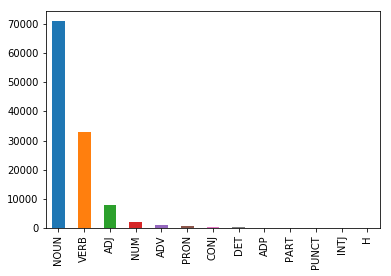

In [15]:
main_poses = candidates.groupby('lemma_id').main_pos.apply(lambda x: pd.value_counts(x).idxmax())
main_poses.value_counts().plot.bar()

Всего в корпусе было выделенно 671527 фраз
Уникальных фраз 163669
После лемматизации уникальных фраз стало 104478


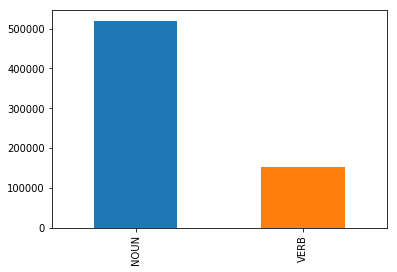

In [16]:
#оставим только фраз, где корнем в синтаксическом дереве является либо сущиствительное (NOUN), либо глагол (VERB)
candidates = candidates[candidates.main_pos.isin(['NOUN', 'VERB'])]
candidates.to_csv('../data/interim/candidates.csv', index=False)

candidate_lemmas = candidate_lemmas[candidate_lemmas.id.isin(candidates.lemma_id.unique())]
candidate_lemmas.to_csv('../data/interim/candidate_lemmas.csv', index=False)

candidate_forms = candidate_forms[candidate_forms.id.isin(candidates.form_id.unique())]
candidate_forms.to_csv('../data/interim/candidate_forms.csv', index=False)

print(f'Всего в корпусе было выделенно {len(candidates)} фраз')
print(f'Уникальных фраз {len(candidate_forms)}')
print(f'После лемматизации уникальных фраз стало {len(candidate_lemmas)}')

candidates.main_pos.value_counts().plot.bar()

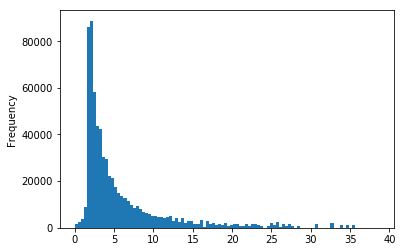

In [17]:
candidates.sig.plot.hist(bins=100)

### Формирование данных для Яндекс.Толока (формат *.tsv)

In [18]:
candidate_forms = pd.read_csv('../data/interim/candidate_forms.csv')
candidate_forms = candidate_forms.candidate.apply(lambda x: x+'\t\t')
candidate_forms = candidate_forms.values[np.random.permutation(len(candidate_forms))]

pull_numbers = 10
pull_size = len(candidate_forms)//pull_numbers+1

for index in range(pull_numbers):

    with open(f'../data/interim/candidate_forms_toloka_{index}.tsv', 'w', encoding='utf-8') as fl:
        fl.write('INPUT:text\tGOLDEN:result\tHINT:text\n')
        fl.write('\n'.join(candidate_forms[index*pull_size:(index+1)*pull_size]))